In [39]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

# Data Loading

In [59]:
df = pd.read_csv('/content/sample_data/processed.csv')
df

,Institution,Course,actor.id,timestamp,verb.id,object.definition.type,result.score.scaled,result.success,result.completion,Teaching
0,UEF,Advanced Data Management Systems,0,2023-07-07 18:55:47,viewed,course,NaN,False,False,Flipped classroom
1,UEF,Advanced Data Management Systems,0,2023-07-07 15:21:18,viewed,link,NaN,False,False,Flipped classroom
2,UEF,Advanced Data Management Systems,0,2023-07-07 15:08:13,viewed,link,NaN,False,False,Flipped classroom
3,UEF,Advanced Data Management Systems,0,2023-07-07 15:08:10,viewed,course,NaN,False,False,Flipped classroom
4,UEF,Advanced Data Management Systems,0,2023-07-07 09:03:32,viewed,course,NaN,False,False,Flipped classroom
...,...,...,...,...,...,...,...,...,...,...
299286,BMU,Computer Networks,820,2023-06-11 22:57:27,answered,cmi.interaction,1.000,True,True,Flipped classroom
299287,BMU,Computer Networks,799,2023-05-16 00:05:45,answered,cmi.interaction,0.000,False,True,Flipped classroom
299288,BMU,Computer Networks,788,2023-05-12 22:10:50,completed,assessment,0.375,True,True,Flipped classroom
299289,BMU,Computer Networks,788,2023-02-27 22:45:33,completed,module,NaN,False,False,Flipped classroom


# Idea 2

In [87]:
def change_assessment(verb, object_def_type):
  if object_def_type != 'assessment':
    return object_def_type

  if verb == 'submit' or verb == 'scored':
    object_def_type = 'homework'
  elif verb == 'completed' or verb == 'start':
    object_def_type = 'test'
  return object_def_type

def get_count(actor_df, object_def_type, verb):
  temp = actor_df[['object.definition.type', 'verb.id']].value_counts()
  if (object_def_type, verb) not in temp.index:
    return (object_def_type, verb, 0)

  count = temp.loc[(object_def_type, verb)]
  return (object_def_type, verb, count)

def get_score(actor_df, object_def_type, verb):
  scores = actor_df[(actor_df['object.definition.type'] == object_def_type) & (actor_df['verb.id'] == verb)]['result.score.scaled']
  if scores.empty:
    return None, None, None

  return min(scores), scores.mean(), max(scores)

def calculate_score(df):
  if df.empty:
    return 0
  total_score = max(0, df[df['result.success'] == True]['result.score.scaled'].fillna(0).mean())
  return total_score

def get_ratio(actor_df: pd.DataFrame, object_definition_type: str, verb_id1: str, verb_id2: str):
  n1 = actor_df[(actor_df['object.definition.type'] == object_definition_type) & (actor_df['verb.id'] == verb_id1)].shape[0]
  n2 = actor_df[(actor_df['object.definition.type'] == object_definition_type) & (actor_df['verb.id'] == verb_id2)].shape[0]
  return None if n2 == 0 else n1 / n2

def get_place_in_course(df, actor_id, course):
  course_df = df[df['Course'] == course]

  scores = []
  actor_score = 0
  for actor in set(course_df['actor.id']):
    actor_df = df[(df['actor.id'] == actor)]
    score = calculate_score(actor_df[actor_df['object.definition.type'].isin(['homework', 'quiz', 'test'])][['result.score.scaled', 'result.success']])
    if actor == actor_id:
      actor_score = score

    scores.append(score)

  return sorted(list(dict.fromkeys(scores)))[::-1].index(actor_score) + 1, len(scores)

def get_place_in_institution(df, actor_id, instituiton):
  instituiton_df = df[df['Institution'] == instituiton]

  scores = []
  actor_score = 0
  for actor in set(instituiton_df['actor.id']):
    actor_df = df[(df['actor.id'] == actor)]
    score = calculate_score(actor_df[actor_df['object.definition.type'].isin(['homework', 'quiz', 'test'])][['result.score.scaled', 'result.success']])
    if actor == actor_id:
      actor_score = score

    scores.append(score)

  return sorted(list(dict.fromkeys(scores)))[::-1].index(actor_score) + 1, len(scores)

def get_successful_assessments(actor_df, type_of_assessment):
  successful_assesment = actor_df[(actor_df['object.definition.type'] == type_of_assessment[0]) & (actor_df['verb.id'] == type_of_assessment[1])]['result.success'].shape[0]
  return successful_assesment

def resume_actor(df, actor_id):
  # This function makes a resume of an actor.

  df = df.copy()
  df['object.definition.type'] = df.apply(lambda row: change_assessment(row['verb.id'], row['object.definition.type']), axis=1)
  df = df[~df['object.definition.type'].isin(['page', 'review', 'meeting', 'survey',  'lesson'])]

  object_definition_types = set(df['object.definition.type'])
  object_def_types_w_verbs = [(object_def_type, verb) for object_def_type in object_definition_types for verb in set(df[df['object.definition.type'] == object_def_type]['verb.id'])]

  items = [] # (object_def_type, verb, count)

  actor_df = df[df['actor.id'] == actor_id]

  for object_def_type, verb in object_def_types_w_verbs:
    object_def_type_with_count = get_count(actor_df, object_def_type, verb)
    items.append(object_def_type_with_count)

  actions_df = pd.DataFrame({'Type': [item[0] for item in items],
                               'Verb': [item[1] for item in items],
                               'Count': [item[2] for item in items]}).sort_values(by=['Count'], ascending = False).reset_index().drop('index', axis=1)

  min_score_homework, avg_score_homework, max_score_homework = get_score(actor_df, 'homework', 'scored')
  min_score_test, avg_score_test, max_score_test = get_score(actor_df, 'test', 'completed')
  min_score_quiz, avg_score_quiz, max_score_quiz = get_score(actor_df, 'quiz', 'completed')

  successful_assessments = [get_successful_assessments(actor_df, type_of_assessment) for type_of_assessment in [('quiz', 'completed'), ('homework', 'scored'), ('test', 'completed')]]



  scores_df = pd.DataFrame({'Type': ['homework', 'test', 'quiz'],
                            'Min_Score': [min_score_homework, min_score_test, min_score_quiz],
                            'Avg_Score': [avg_score_homework, avg_score_test, avg_score_quiz],
                            'Max_Score': [max_score_homework, max_score_test, max_score_quiz]})

  course = actor_df['Course'].iloc[0]
  institution = actor_df['Institution'].iloc[0]

  place_in_course = get_place_in_course(df, actor_id, course)
  place_in_institution = get_place_in_institution(df, actor_id, institution)
  place = [place_in_course, place_in_institution]

  return actions_df, scores_df, successful_assessments, place

def display(df, id_or_name):
  actions_df = None
  scores_df = None
  successful_assessments = None
  total_students = None
  total_students_in_courses = None
  place = None

  if type(id_or_name) is int:
    actions_df, scores_df, successful_assessments, place = resume_actor(df, id_or_name)
  else:
    actions_df, scores_df, successful_assessments, total_students, total_students_in_courses = resume_course_or_institution(df, id_or_name)

  fig = px.treemap(data_frame=actions_df, path=['Verb', 'Type'], values='Count', title='Actions')
  fig.show()

  scores_df = scores_df.fillna(0)
  scores_df = scores_df[(scores_df['Min_Score'] != 0) | (scores_df['Avg_Score'] != 0) | (scores_df['Max_Score'] != 0)]

  bar_width = 0.2
  bar_positions = range(len(scores_df))

  plt.bar([pos - bar_width for pos in bar_positions], scores_df['Min_Score'], width=bar_width, label='Min Score')
  plt.bar(bar_positions, scores_df['Avg_Score'], width=bar_width, label='Avg Score')
  plt.bar([pos + bar_width for pos in bar_positions], scores_df['Max_Score'], width=bar_width, label='Max Score')

  for pos, min_score, avg_score, max_score in zip(bar_positions, scores_df['Min_Score'], scores_df['Avg_Score'], scores_df['Max_Score']):
    plt.text(pos - bar_width, min_score, str(min_score)[:5], ha='center', va='bottom')
    plt.text(pos, avg_score, str(avg_score)[:5], ha='center', va='bottom')
    plt.text(pos + bar_width, max_score, str(max_score)[:5], ha='center', va='bottom')

  plt.xlabel('Type')
  plt.ylabel('Score')
  plt.title('Scores')

  plt.yticks([])
  plt.xticks(bar_positions, scores_df['Type'])
  plt.legend()

  if place is not None:
    fig, ax = plt.subplots(nrows = 2, ncols = 1)

    x = [1, place[0][0], place[0][1]]
    y = [1, place[1][0], place[1][1]]
    idx = np.arange(1,len(x)+1)
    for i in range(2):
      ax[i].spines['top'].set_visible(False)
      ax[i].spines['right'].set_visible(False)
      ax[i].spines['left'].set_visible(False)
      ax[i].spines['bottom'].set_position('zero')
      ax[i].spines['bottom'].set_alpha(0.2)
      ax[i].get_yaxis().set_visible(False)
    ax[0].scatter(x, np.zeros(len(x)), c = 'white')
    ax[0].scatter(x[1], 0, s=300, c='lightgreen')
    ax[0].set_title('Place in Course')

    ax[1].scatter(y, np.zeros(len(x)), c = 'white')
    ax[1].scatter(y[1], 0, s=300, c='lightsteelblue')
    ax[1].set_title('Place in Institution')

  plt.show()


In [32]:
def resume_course_or_institution(df, id):

  institutions = set(df['Institution'])

  type_object = 'Institution' if id in institutions else 'Course'

  df = df.copy()
  df['object.definition.type'] = df.apply(lambda row: change_assessment(row['verb.id'], row['object.definition.type']), axis=1)
  df = df[~df['object.definition.type'].isin(['page', 'review', 'meeting', 'survey',  'lesson'])]

  object_definition_types = set(df['object.definition.type'])
  object_def_types_w_verbs = [(object_def_type, verb) for object_def_type in object_definition_types for verb in set(df[df['object.definition.type'] == object_def_type]['verb.id'])]

  items = [] # (object_def_type, verb, count)

  object_df = df[df[type_object] == id]
  total_students = len(set(object_df['actor.id']))
  total_students_in_courses = None if type_object == 'Course' else object_df.groupby('Course')['actor.id'].nunique().reset_index().rename(columns = {'actor.id': 'Count'})

  for object_def_type, verb in object_def_types_w_verbs:
    object_def_type_with_count = get_count(object_df, object_def_type, verb)
    items.append(object_def_type_with_count)

  actions_df = pd.DataFrame({'Type': [item[0] for item in items],
                               'Verb': [item[1] for item in items],
                               'Count': [item[2] for item in items]}).sort_values(by=['Count'], ascending = False).reset_index().drop('index', axis=1)

  min_score_homework, avg_score_homework, max_score_homework = get_score(object_df, 'homework', 'scored')
  min_score_test, avg_score_test, max_score_test = get_score(object_df, 'test', 'completed')
  min_score_quiz, avg_score_quiz, max_score_quiz = get_score(object_df, 'quiz', 'completed')

  successful_assessments = [get_successful_assessments(object_df, type_of_assessment) for type_of_assessment in [('quiz', 'completed'), ('homework', 'scored'), ('test', 'completed')]]

  scores_df = pd.DataFrame({'Type': ['homework', 'test', 'quiz'],
                            'Min_Score': [min_score_homework, min_score_test, min_score_quiz],
                            'Avg_Score': [avg_score_homework, avg_score_test, avg_score_quiz],
                            'Max_Score': [max_score_homework, max_score_test, max_score_quiz]})

  return actions_df, scores_df, successful_assessments, total_students, total_students_in_courses

In [35]:
d = resume_course_or_institution(df, 'UEF')

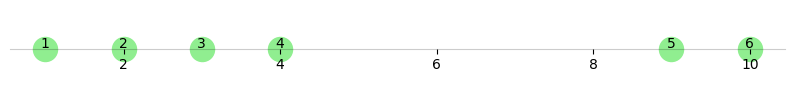

In [64]:
fig, ax = plt.subplots(figsize=(10,1))

x = [1,2,3,4,9,10]
idx = np.arange(1,len(x)+1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_position('zero')
ax.spines['bottom'].set_alpha(0.2)
ax.get_yaxis().set_visible(False)
ax.scatter(x, np.zeros(len(x)), s=300, c='lightgreen')

for i in range(len(idx)):
    ax.annotate(idx[i], (x[i], 0), textcoords="offset points",
                xytext=(0,0), # distance from text to points (x,y)
                ha='center')
plt.show()

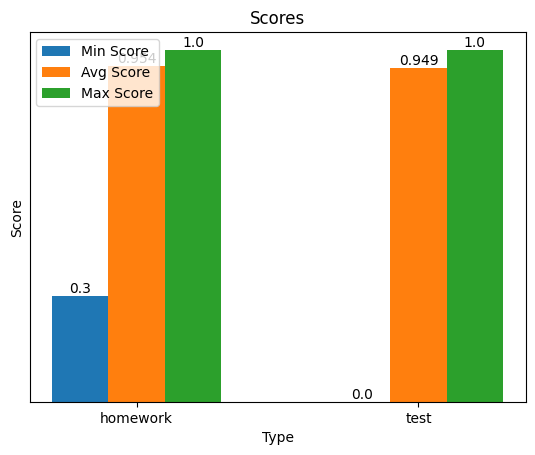

In [88]:
display(df, 'UEF')